# Анализ метрики линеаризованных лайков

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  $\frac {𝑥}{𝑦}$  (У нас $\frac {clicks}{likes}$).

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). 

Задача

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?



## Загрузка данных

In [2]:
### импортирую необходимые библиотеки

import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
### подключаюсь к бд

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}


### вывожу нужный датафрейм по датам и группам

query = ''' 
            SELECT exp_group, 
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes/views as ctr
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2023-01-01' and '2023-01-07'
                and exp_group in (0,1,2,3)
            GROUP BY exp_group, user_id
        '''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125


In [12]:
### cчитаю общий ctr в контрольных группах

df_g03_cntrlctr = sum(df[df.exp_group == 0].likes)/sum(df[df.exp_group == 0].views)
print(df_g03_cntrlctr, '0 группа')

df_g12_cntrlctr = sum(df[df.exp_group == 1].likes)/sum(df[df.exp_group == 1].views)
print(df_g12_cntrlctr, '1 группа')

0.20823612262916305 0 группа
0.20802680490126244 1 группа


In [16]:
### cчитаю в обеих группах поюзерную метрику 

linearized_likes0 = df[df.exp_group == 0].likes - df_g03_cntrlctr * df[df.exp_group == 0].views
linearized_likes3 = df[df.exp_group == 3].likes - df_g03_cntrlctr * df[df.exp_group == 3].views

linearized_likes1 = df[df.exp_group == 1].likes - df_g12_cntrlctr * df[df.exp_group == 1].views
linearized_likes2 = df[df.exp_group == 2].likes - df_g12_cntrlctr * df[df.exp_group == 2].views

## 1.  t-тест

In [17]:
### провожу t-тест для 0 и 3 группы

stats.ttest_ind(linearized_likes0,
                linearized_likes3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [18]:
### провожу t-тест для 1 и 2 группы

stats.ttest_ind(linearized_likes1,
                linearized_likes2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

t-тест для группы 0 и 3 и для группы 1 и 2 показал pvalue << 0,05, значит между ними есть статистически значимые различия.

## 2. Визуализирую распределение linearized_likes

In [20]:
### создаю колонку для новой метрики

df.loc[df['exp_group'] == 0,'linearized_likes'] = linearized_likes0
df.loc[df['exp_group'] == 1,'linearized_likes'] = linearized_likes1
df.loc[df['exp_group'] == 2,'linearized_likes'] = linearized_likes2
df.loc[df['exp_group'] == 3,'linearized_likes'] = linearized_likes3
df.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,1,18392,7,32,0.218750,0.343142
2,3,123580,13,48,0.270833,3.004666
3,2,131473,14,134,0.104478,-13.875592
4,2,32420,26,128,0.203125,-0.627431


In [22]:
### создаю 2 датафрейма с колонкой новой метрики 

df_g03 = df.query('exp_group == 0 or exp_group == 3')
df_g12 = df.query('exp_group == 1 or exp_group == 2')

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

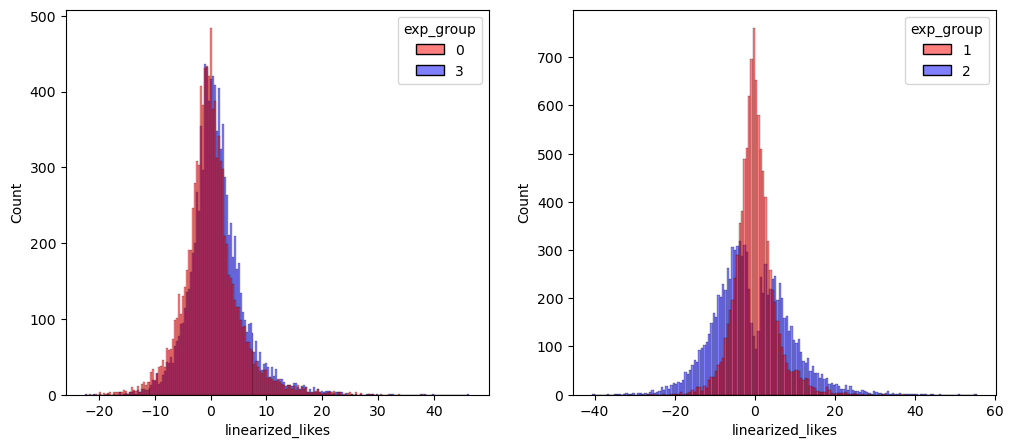

In [28]:
f, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data = df_g03, 
            x='linearized_likes', 
            hue='exp_group', 
            palette = ['r', 'b'],
            alpha=0.5,
            ax=axs[0],
            kde=False)


sns.histplot(data = df_g12, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              ax=axs[1],
              kde=False)

## Вывод

Проведя сравнения метрики линеаризации с обычным ctr можно заключить:

* Метод линеаризации значительно повысел чувствительность;
* 0, 3 и 1, 2 группы показали в t-тестах статистически значимые различия p-value << 0,05, что было сложно увидеть при обычном ctr, как метрике; 
* p-value в обоих группах стало значительно меньше.